In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pickle as pkl
import pandas as pd
from scipy.signal import savgol_filter
import os
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from dtw import dtw
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.special import softmax
from scipy.signal import find_peaks, gaussian, convolve
from scipy.ndimage import gaussian_filter1d
import diptest
from sklearn.utils import resample

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
PHOTROOT = "/mnt/Astronomy/GraduateSchool/Thesis/GCConsistency/NGC2808/photometry/HUGS/ngc2808/photometry.pkl"

In [3]:
densityCache = "/mnt/Astronomy/packages/localTests/fidanka/MC_1_Density.npz"
assert os.path.exists(densityCache), "Density Cache File not Found!" 

In [4]:
def binDensityKeepingCountingStatisticsTheSame(color, mag, density, targetStat=1000):
    srtedIDX = np.argsort(mag)
    sMag = mag[srtedIDX]
    sColor = color[srtedIDX]
    sDensity = density[srtedIDX]
    subs = np.floor(sMag.shape[0]/targetStat).astype(int)
    binsM = np.array_split(sMag, subs)
    binsC = np.array_split(sColor, subs)
    binsD = np.array_split(sDensity, subs)
    
    return binsC, binsM, binsD

In [5]:
def clean_bins(colorBins, magBins, densityBins, sigma=5):
    newColorBins = list()
    newMagBins = list()
    newDensityBins = list()
    for i, (color, mag, density) in enumerate(zip(colorBins, magBins, densityBins)):
        meanColor = np.mean(color)
        stdColor = np.std(color)
        cut = (color >= meanColor - sigma*stdColor) & (color < meanColor + sigma*stdColor)
        newColorBins.append(color[cut])
        newMagBins.append(mag[cut])
        newDensityBins.append(density[cut])
    return newColorBins, newMagBins, newDensityBins

In [6]:
def normalize_density_magBin(color, mag, density, binSize=0.1):
    normDensity = np.zeros(shape=color.shape[0])
    for IDx, (c, m, d) in tqdm(enumerate(zip(color, mag, density)), total=len(density)):
        cut = (mag > m-binSize/2) & (mag <= m+binSize/2)
        binDensity = density[cut]
        meanBinDensity = np.mean(binDensity)
        normalizedDensity = d/meanBinDensity
        normDensity[IDx] = normalizedDensity
    return normDensity

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 38319/38319 [00:18<00:00, 2089.74it/s]


Iterating Cleaning
Iterating Cleaning
Iterating Cleaning
Iterating Cleaning
Iterating Cleaning


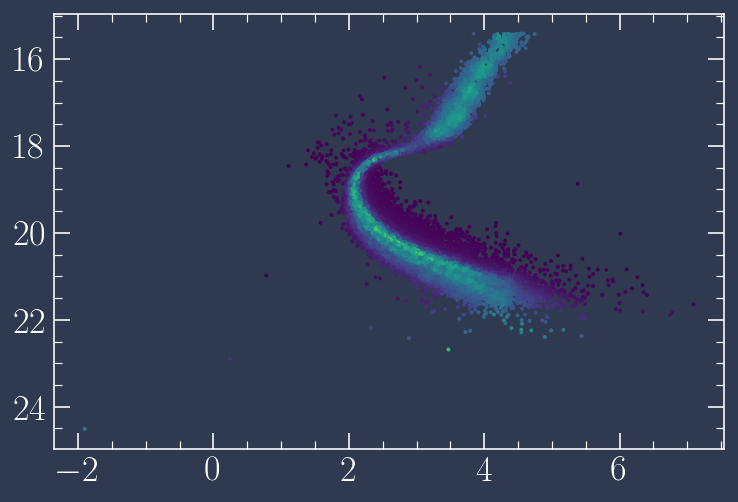

In [7]:
density = np.load(densityCache)['density']
with open(PHOTROOT, 'rb') as f:
    HUGSPhotometry = pkl.load(f)[1]
color = HUGSPhotometry["F275W"] - HUGSPhotometry["F814W"]
mag = HUGSPhotometry["F814W"]
density = normalize_density_magBin(color, mag, density, binSize=0.5)
HUGSPhotometry['density'] = density
plt.scatter(color, mag, s=1, c=density)
plt.gca().invert_yaxis()
colorBins, magBins, densityBins = binDensityKeepingCountingStatisticsTheSame(color.values, mag.values, density, targetStat=250)

for i in range(5):
    print("Iterating Cleaning")
    colorBins, magBins, densityBins = clean_bins(colorBins, magBins, densityBins, sigma=2.5)
    
cleanedColor = np.concatenate(colorBins, axis=None)
cleanedMag = np.concatenate(magBins, axis=None)
cleanedDensity = np.concatenate(densityBins, axis=None)

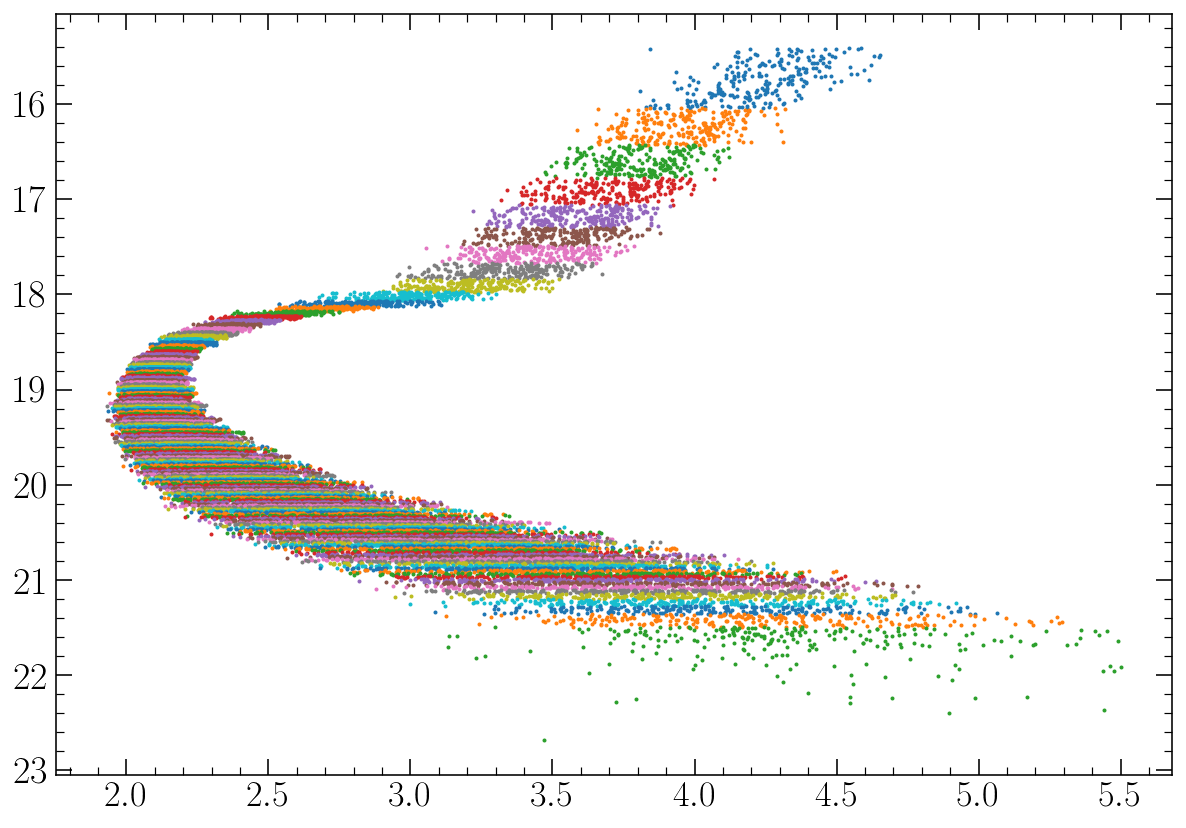

In [8]:
with plt.style.context(pubStyle):
    fig, ax = plt.subplots(1,1,figsize=(10,7))
    for cB, mB in zip(colorBins, magBins):
        ax.scatter(cB, mB, s=1)
    ax.invert_yaxis()

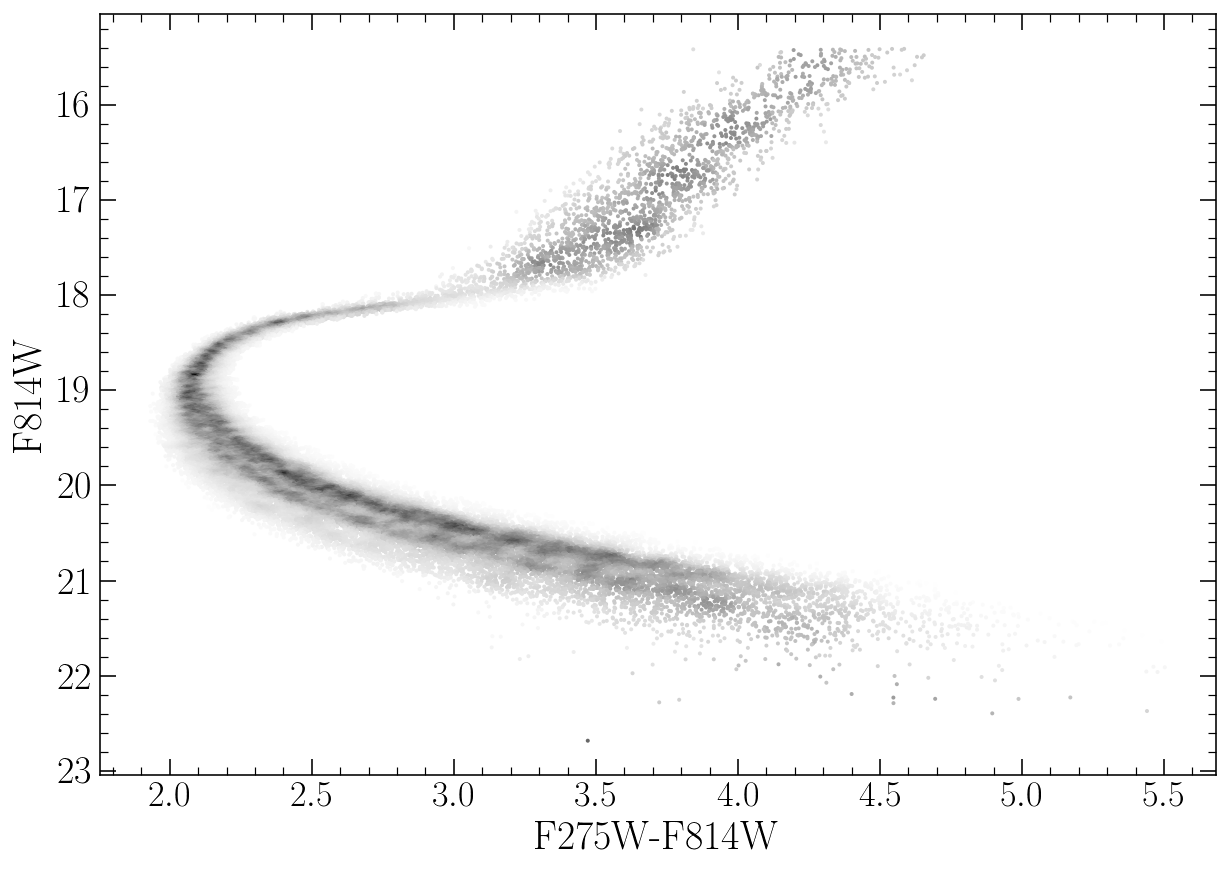

In [9]:
with plt.style.context(pubStyle):
    fig, ax = plt.subplots(1,1,figsize=(10,7))
    # for c, m,d in zip(colorBins, magBins, densityBins):
    #     ax.scatter(c,m,s=1,c=d)
    ax.scatter(cleanedColor, cleanedMag, c=cleanedDensity, s=1, cmap='Greys')
    ax.invert_yaxis()
    
    ax.set_xlabel("F275W-F814W")
    ax.set_ylabel("F814W")
    fig.savefig("Figures/AdaptiveBinning.png", dpi=200)

In [10]:
def build_mixture_model(n, max_iter=None, wcp=None, rs=42, bay=False):
    if bay:
        mm = BayesianGaussianMixture(
            n_components=n,
            max_iter=max_iter,
            weight_concentration_prior=wcp,
            random_state=rs)
    else:
        mm = GaussianMixture(n_components=n, random_state=rs)
    return mm

In [11]:
def GMM_component_measurment(xB, yB, zB=None, n=50, bay=False, max_iter=500):
    if zB is not None:
        checkz = True
    else:
        checkz = False
    n_bins = len(xB)
    # This will store the GMM means for each bin
    gmm_means = list()
    gmm_weights = list()
    dataL = list()
    component_weights = np.zeros(shape=(n_bins, n), dtype=np.float64)
    mm1 = build_mixture_model(n, max_iter=max_iter, wcp=1/(2*np.sqrt(n_bins)), bay=bay)
    mm2 = build_mixture_model(1, max_iter=max_iter, wcp=1/(2*np.sqrt(n_bins)), bay=bay)
    mm = mm1
    
    for i_bin in range(n_bins):
        if checkz:
            z = zB[i_bin]
            if z > 18:
                mm = mm1
            if 18 <= z <= 19.1:
                # print("Using single population model")
                mm = mm2
            else:
                mm = mm1
        # Prepare the data for this bin
        x_bin = xB[i_bin]
        y_bin = yB[i_bin]
                
        # if bay:
        y_bin = np.exp(y_bin)
        weights = y_bin / np.sum(y_bin)

        # Fit a GMM to the color distribution, weighted by the densities
        data = np.vstack((x_bin, weights)).T
        dataL.append(data)
        mm.fit(data)

        # Store the means
        if checkz and (18 <= z <= 19.1):
            stretched = np.zeros(shape=(n,2))
            for i in range(n):
                stretched[i] = mm.means_
            gmm_means.append(stretched)
        else:
            gmm_means.append(mm.means_)
        component_weights[i_bin, :] = mm.weights_
            

    # Convert to numpy array for further processing
    weight_threshold = 0.025
    gmm_means = np.squeeze(gmm_means)
    gmm_weights = np.squeeze(gmm_weights)
    n_components_per_bin = (component_weights > weight_threshold).sum(axis=1)
    return gmm_means[:,:,0], gmm_means[:,:,1], component_weights, n_components_per_bin, dataL

In [12]:
gmm_color_means, gmm_density_means, cw, ncb, dL= GMM_component_measurment(colorBins, densityBins, n=20, bay=False)
# Plot the GMM means

colorGMM = np.median(gmm_color_means, axis=1)
magGMM = [np.mean(x) for x in magBins]

# highPercentile = savgol_filter(np.percentile(gmm_means, 68.27, axis=1), 10, 2)
# lowPercentile = savgol_filter(np.percentile(gmm_means, 100-68.27, axis=1), 10, 2)

smoothedColor = savgol_filter(colorGMM, 20, 2)
fbase = np.zeros(shape=(len(magGMM), 4))
fbase[:,0] = smoothedColor
fbase[:,1] = magGMM
# fbase[:,2] = lowPercentile
# fbase[:,3] = highPercentile

# with plt.style.context(pubStyle):
#     fig, ax = plt.subplots(1,1,figsize=(10,7))
#     # for i_component in range(n_components):
#     #     ax.plot(gmm_means[:, i_component],[np.mean(x) for x in magBins], label=f'Component {i_component+1}', alpha=0.1)
#     ax.set_xlabel('F275W-F814W')
#     ax.set_ylabel('F814W')
#     ax.scatter(cleanedColor, cleanedMag, c=cleanedDensity, s=1, cmap="Greys")
#     ax.plot(fbase[:,0], fbase[:,1], 'red')
#     # ax.set_xlim(1.9, 5)
#     # ax.set_ylim(15, 22)
#     ax.invert_yaxis()
#     fig.savefig("Figures/GMMMixing.png", dpi=200)
#     # plt.legend()

In [13]:
fBaseF = interp1d(fbase[:, 1], fbase[:, 0], bounds_error=False, fill_value='extrapolate')

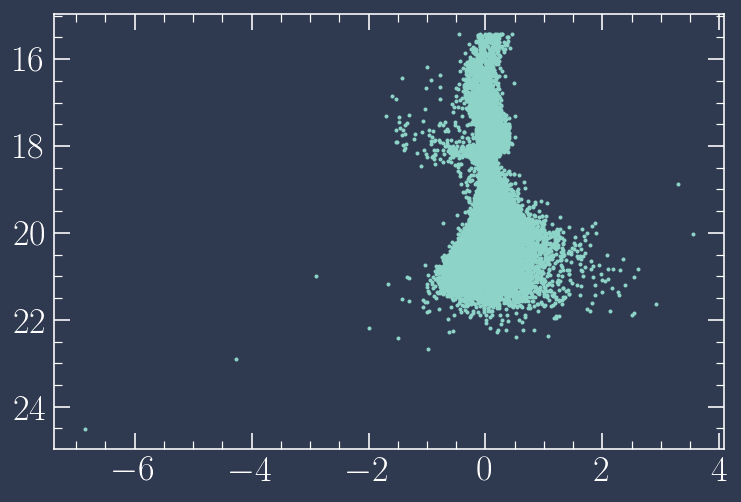

In [14]:
plt.scatter(color-fBaseF(mag), mag, s=1)
plt.gca().invert_yaxis()

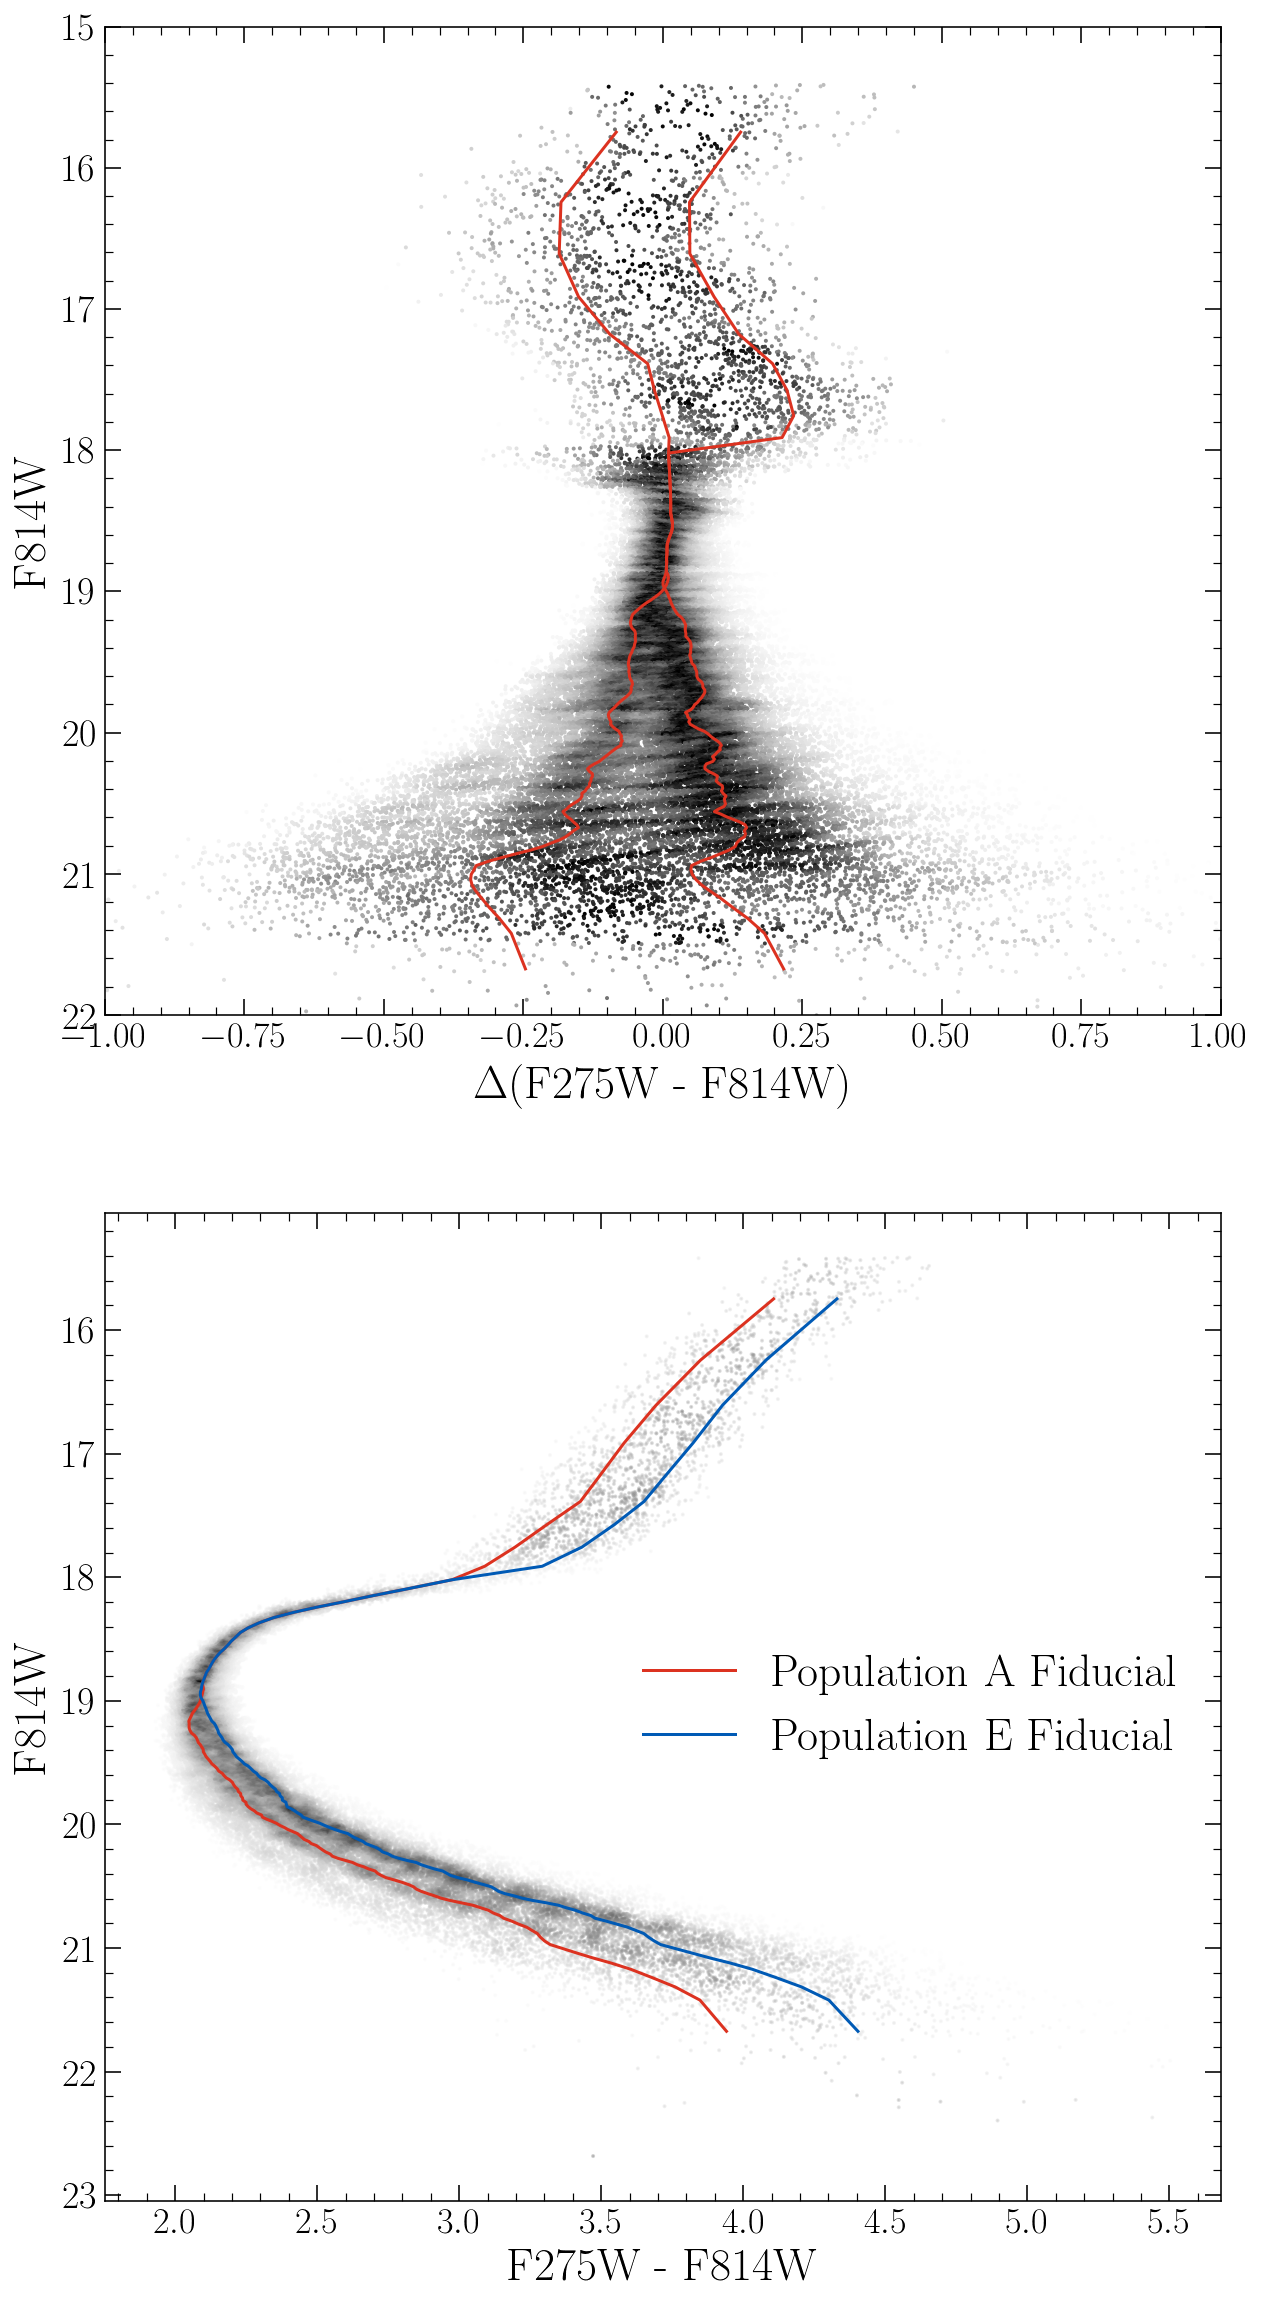

In [17]:
with plt.style.context(pubStyle):
    fig, axs = plt.subplots(2,1,figsize=(10,20))
    ax = axs[0]
    # fBaseF = interp1d(fbase[:,1], fbase[:,0], bounds_error=False, fill_value='extrapolate')
    color = HUGSPhotometry["F275W"] - HUGSPhotometry["F814W"]
    mag = HUGSPhotometry["F814W"]
    vColor = color-fBaseF(mag)
    vMag  = mag
    vDensity = HUGSPhotometry['density']
    vColorBins, vMagBins, vDensityBins = binDensityKeepingCountingStatisticsTheSame(vColor.values, vMag.values, vDensity, targetStat=250)
    
    for _ in range(5):
        vColorBins, vMagBins, vDensityBins = clean_bins(vColorBins, vMagBins, vDensityBins, sigma=3)
    for vCB, vMB, vDB in zip(vColorBins, vMagBins, vDensityBins):
        ax.scatter(vCB, vMB, c=vDB, s=1, cmap="Greys")

    n_expected_lines = 2
    gmmMags = np.array([np.mean(x) for x in vMagBins])
    gmm_vert_color_means, gmm_vert_density_means, gmm_vert_comp_weights, gmm_vert_per_bin, dL = GMM_component_measurment(vColorBins, vDensityBins, zB=gmmMags, n=n_expected_lines, bay=True)
    gmmColorMean = np.median(gmm_vert_color_means, axis=1)
    gmmColorMean[gmmMags > 18.5] = savgol_filter(gmmColorMean[gmmMags>18.5],20,2)
    # ax.plot(gmmColorMean, gmmMags, 'red')

    lines = np.zeros(shape=(len(gmmMags),n_expected_lines))
    weights = np.zeros_like(lines)
    for idx, (cs, w, m) in enumerate(zip(gmm_vert_color_means, gmm_vert_comp_weights, gmmMags)):
        sid = np.argsort(cs)
        lines[idx] = cs[sid]
        weights[idx] = w[sid]


    for lineID in range(n_expected_lines):
        lines[gmmMags > 18, lineID] = savgol_filter(lines[gmmMags > 18, lineID], 20, 2)
    lines[gmmMags > 19, 1] -= np.exp(np.linspace(0, 0.19, lines[gmmMags > 19, 1].shape[0]))-1
    # lines[m > 18, :] = savgol_filter(lines[m > 18, :], 20,2)
    for i in range(n_expected_lines):
        ax.plot(lines[:, i], gmmMags, '#DC3220')
    ax.set_ylim(15, 22)
    ax.set_xlim(-1, 1)
    ax.invert_yaxis()
    
    ax.set_xlabel("$\Delta$(F275W - F814W)", fontsize=23)
    ax.set_ylabel("F814W", fontsize=23)
    
    ax2 = axs[1]
    fBaseF = interp1d(fbase[:,1], fbase[:,0], bounds_error=False, fill_value='extrapolate')
    color = HUGSPhotometry["F275W"] - HUGSPhotometry["F814W"]
    mag  = HUGSPhotometry["F814W"]
    density = HUGSPhotometry['density']
    colorBins, magBins, densityBins = binDensityKeepingCountingStatisticsTheSame(color.values, mag.values, density.values, targetStat=250)
    ax2.scatter(cleanedColor, cleanedMag, c=cleanedDensity, cmap="Greys", s=1, alpha=0.3)
    ax2.invert_yaxis()
    # ax.plot(gmmColorMean+fBaseF(gmmMags), gmmMags, 'red')
    ax2.plot(lines[:, 0] + fBaseF(gmmMags), gmmMags, '#DC3220', label="Population A Fiducial")
    ax2.plot(lines[:, 1] + fBaseF(gmmMags), gmmMags, '#005AB5', label="Population E Fiducial")
    
    ax2.legend(loc='best', fontsize=23, frameon=False)

    ax2.set_xlabel("F275W - F814W", fontsize=23)
    ax2.set_ylabel("F814W", fontsize=23)
    
    fig.savefig("Figures/VertFit.png", dpi=200)
    fig.savefig("Figures/VertFit.pdf")
    
    with open("ExampleFidOutput.pkl", 'wb') as f:
        pkl.dump({'mag': gmmMags, 'Acolor': lines[:, 0] + fBaseF(gmmMags), 'Bcolor': lines[:, 1] + fBaseF(gmmMags)}, f)

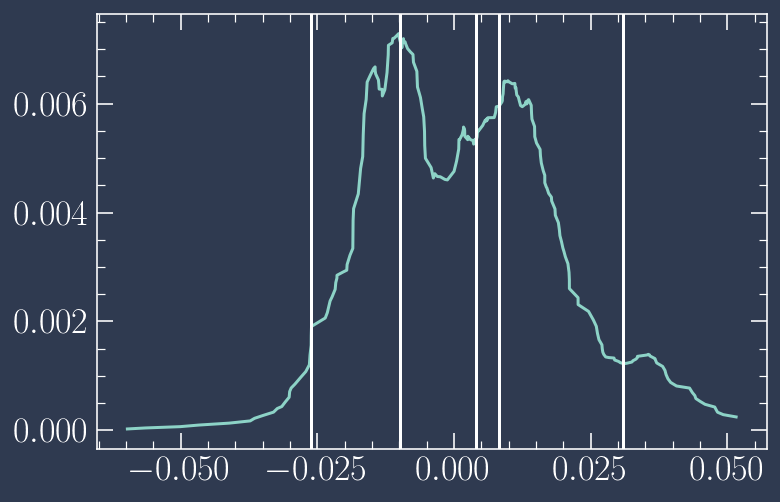

In [20]:
# binID = 39
binID = 130
# binID = 100
n = 5
cBinTemp, dBinTemp = vColorBins[binID], vDensityBins[binID]
cBinTemp, dBinTemp = cBinTemp[np.argsort(cBinTemp)], dBinTemp[np.argsort(cBinTemp)]

gmm = BayesianGaussianMixture(n_components=n,
                             random_state=42,
                             weight_concentration_prior=1/(2*n))

weights = np.power(savgol_filter(dBinTemp, 20, 2), 2)
weights = weights/np.sum(weights)

colorNorm = cBinTemp/np.sum(cBinTemp)

plt.plot(colorNorm, weights)
data = np.vstack((colorNorm, weights)).T
gmmr = gmm.fit(data)
gmm.fit(data)
means = gmm.means_
for mean in means:
    plt.axvline(mean[0])

5


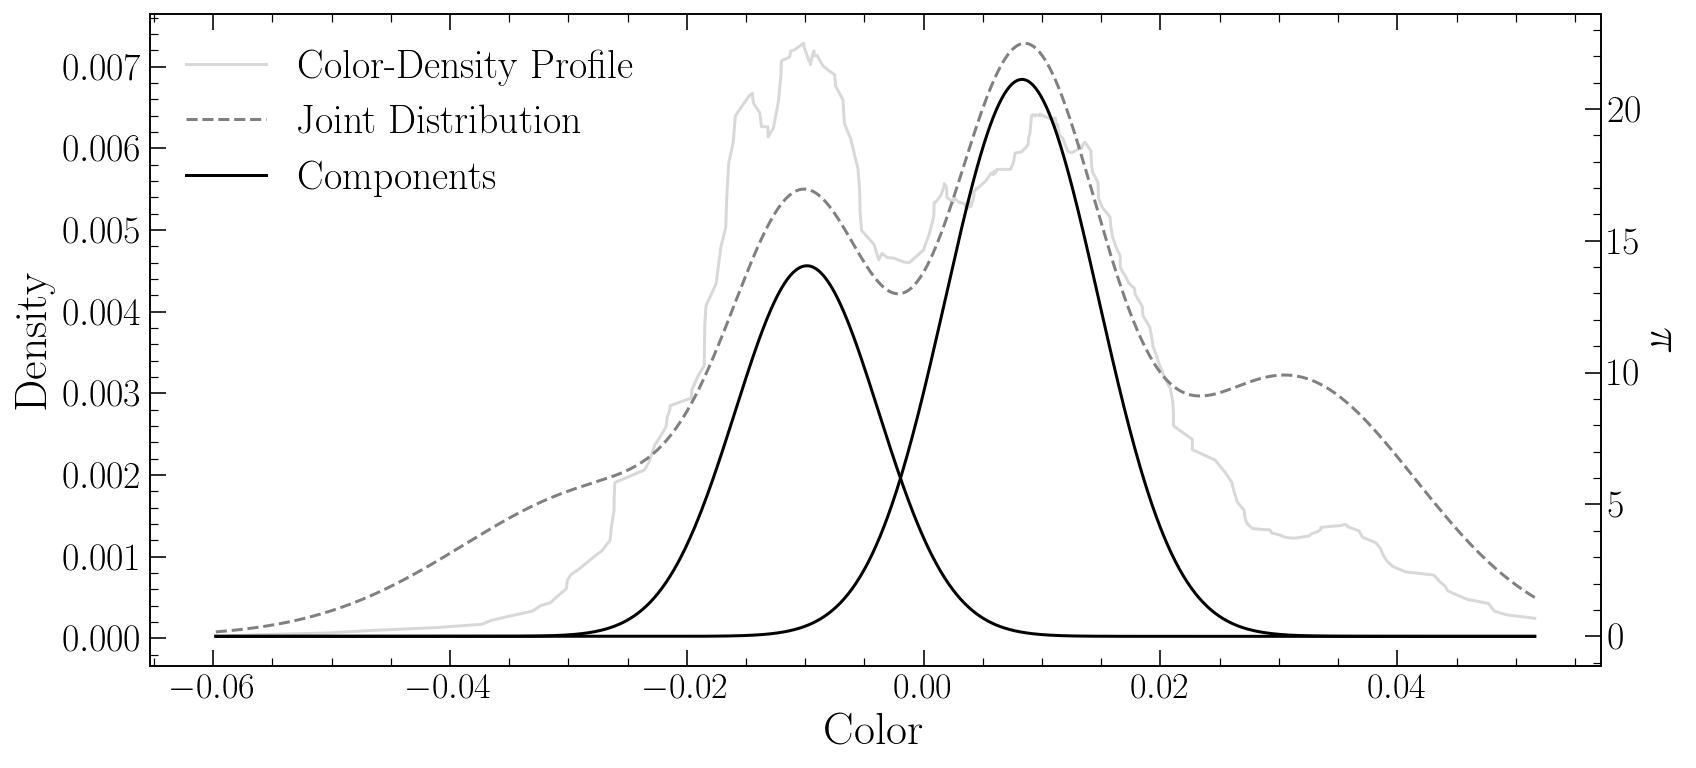

In [21]:
from scipy.stats import norm

# Assume you've already fit your GMM and it's called 'gmm'
# Assume that 'data' is your original 1D data

# Plot the original data

# Create an array of x values spanning the range of your data
x = np.linspace(min(data[:, 0]), max(data[:, 0]), 1000)
dists = list()
# For each component in the GMM
print(gmm.n_components)
for i in range(gmm.n_components):
    # Retrieve the parameters of the Gaussian distribution
    mean = gmm.means_[i][0]
    std_dev = np.sqrt(np.diag(gmm.covariances_[i]))[0]  # Covariance is the square of standard deviation
    weight = gmm.weights_[i]

    # Create the Gaussian distribution for this component
    gaussian = norm(loc=mean, scale=std_dev)

    # Plot the Gaussian distribution, scaling it by the component weight
    Y = weight * gaussian.pdf(x)
    dists.append(Y)
    # plt.plot(x, Y, label=f'Component {i+1}')
with plt.style.context(pubStyle):
    fig, ax = plt.subplots(1,1,figsize=(13,6))
    dl = ax.plot(data[:,0], data[:,1], alpha=0.3, color='grey', label="Color-Density Profile")
    ax2 = ax.twinx()
    dists = np.array(dists)
    joint = dists.sum(axis=0)
    jl = ax2.plot(x, joint, color='grey', linestyle='dashed', label="Joint Distribution")
    normDists = dists
    distPeaks = np.max(normDists, axis=1)
    ax.set_xlabel('Color', fontsize=23)
    ax.set_ylabel('Density', fontsize=23)
    ax2.set_ylabel('$\pi$', fontsize=23, rotation=270, labelpad=20)
    meanJointVal = np.mean(joint)

    highest = means[np.argsort(means[:, 1])][-2:]
    # ax2.axhline(meanJointVal, linestyle='dashed')

    peakDistFromMean =  distPeaks - meanJointVal
    sortededDists = np.argsort(peakDistFromMean)[::-1]
    sortedMeans = means[sortededDists]
    sortedDistsD = dists[sortededDists]
    prefixLookup = {0: 'th', 1: 'st', 2: 'nd', 3: 'rd'}
    def get_lookup(i):
        if i in prefixLookup:
            return prefixLookup[i]
        else:
            return 'th'
    for i, d in enumerate(sortedDistsD[:2]):
        suffix = get_lookup(i+1)
        pl = ax2.plot(x, d, color='black', label=rf"Components")
    lns = dl + jl + pl
    lbs = [x.get_label() for x in lns]
    ax.legend(lns, lbs, fontsize=20, loc='upper left', frameon=False)
    # ax2.legend(fontsize=23, frameon=False, borderpad=50)
    # for i, (dp, pdm) in enumerate(zip(distPeaks, peakDistFromMean)):
    #     ax2.axhline(dp, label=pdm, color=f"C{i}")
    # ax2.legend()
    # for i, mean in enumerate(sortedMeans[:2]):
    #     ax.axvline(mean[0], color=f'C{i}')
    # print(np.sort(peakDistFromMean))
    # print(distPeaks)

    # for c in highest:
    #     plt.axvline(c[0])
    fig.savefig("Figures/BGMMMixingBin.pdf")

In [ ]:
sortedDistsD.shape

In [ ]:
plt.hist(means[:, 1] - np.mean(means[:, 1]))

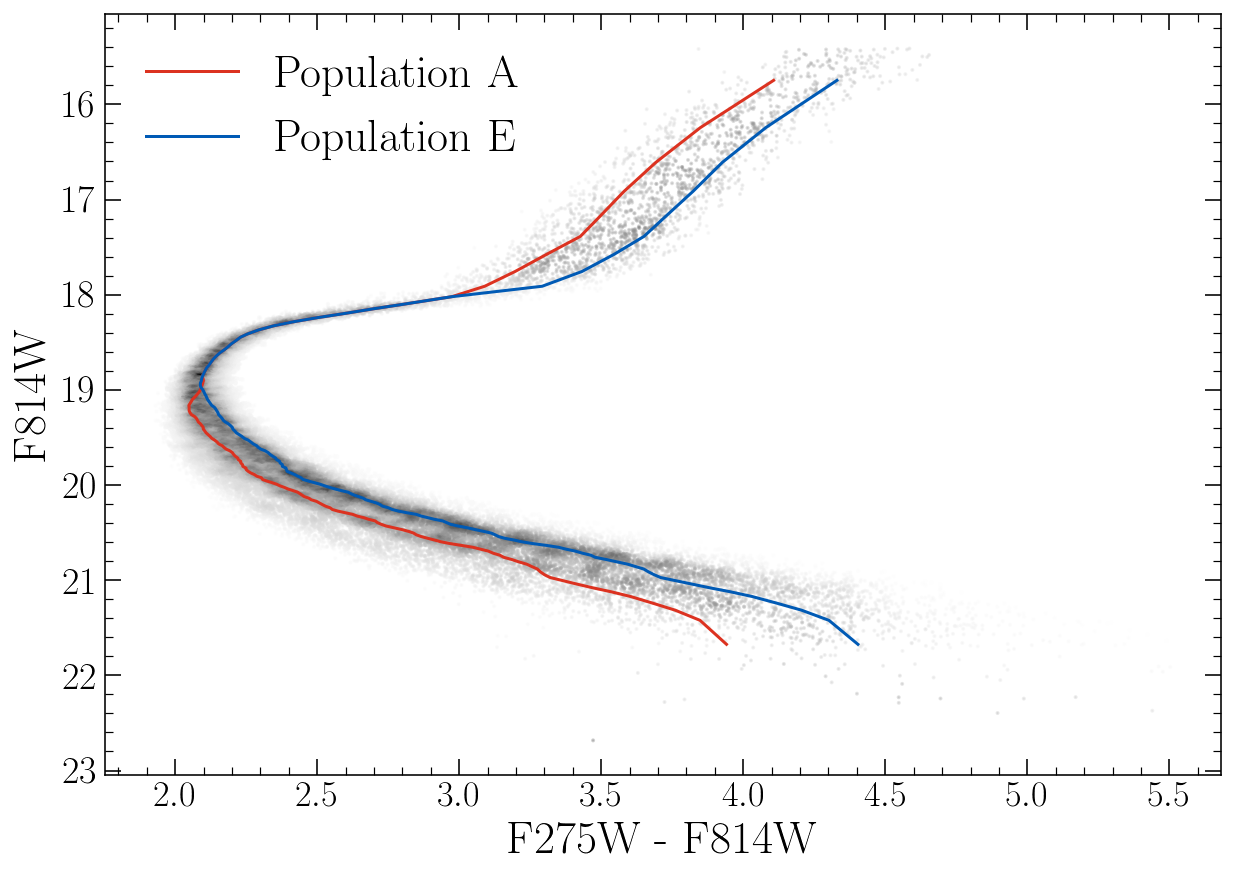

In [22]:
with plt.style.context(pubStyle):
    fig, ax = plt.subplots(1,1,figsize=(10,7))
    fBaseF = interp1d(fbase[:,1], fbase[:,0], bounds_error=False, fill_value='extrapolate')
    color = HUGSPhotometry["F275W"] - HUGSPhotometry["F814W"]
    mag  = HUGSPhotometry["F814W"]
    density = HUGSPhotometry['density']
    colorBins, magBins, densityBins = binDensityKeepingCountingStatisticsTheSame(color.values, mag.values, density.values, targetStat=250)
    ax.scatter(cleanedColor, cleanedMag, c=cleanedDensity, cmap="Greys", s=1, alpha=0.3)
    ax.invert_yaxis()
    # ax.plot(gmmColorMean+fBaseF(gmmMags), gmmMags, 'red')
    ax.plot(lines[:, 0] + fBaseF(gmmMags), gmmMags, '#DC3220', label="Population A")
    ax.plot(lines[:, 1] + fBaseF(gmmMags), gmmMags, '#005AB5', label="Population E")
    
    ax.legend(loc='best', fontsize=23, frameon=False)

    ax.set_xlabel("F275W - F814W", fontsize=23)
    ax.set_ylabel("F814W", fontsize=23)
    
    fig.savefig("Figures/Fiducials.pdf")
    fig.savefig("Figures/Fiducials.png", dpi=200)

In [23]:
densityNorm = data[:, 1] / np.sum(data[:, 1])
cdf = np.cumsum(densityNorm)
n_samples = 2000  # Specify the number of samples you want to generate
samples = np.random.rand(n_samples)
sampled_colors = np.array([data[:, 0][np.searchsorted(cdf, s)] for s in samples])
sampled_density = np.array([data[:, 1][np.searchsorted(cdf, s)] for s in samples])
dip_value, p_value= diptest.diptest(sampled_colors)
print(f"dip value is {dip_value}, p value is {p_value}")

dip value is 0.0439848355415329, p value is 0.0


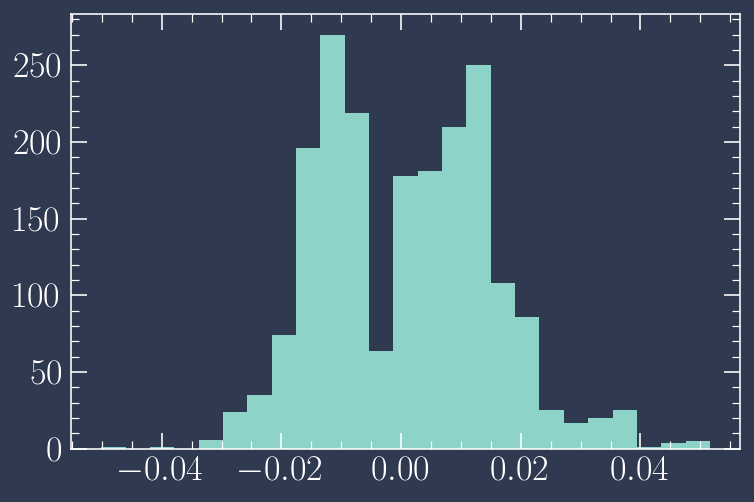

In [24]:
plt.hist(sampled_colors, bins=25);

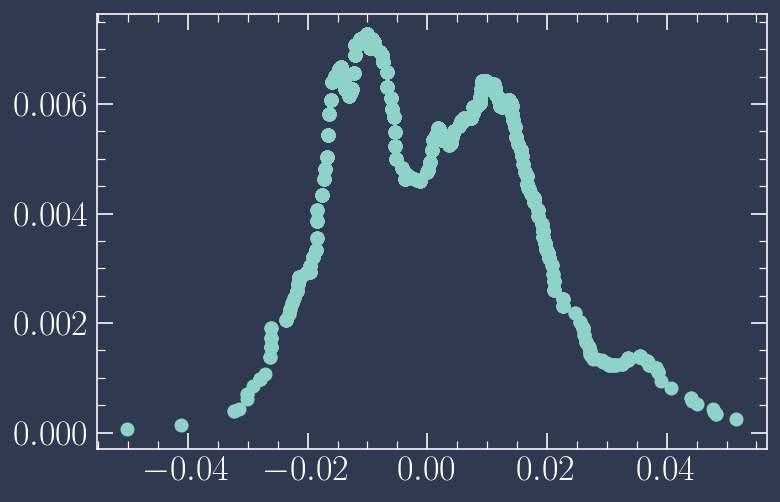

In [25]:
plt.plot(sampled_colors, sampled_density, 'o')

(0.0037140084615880048, 1.0)
(0.01555652306954831, 0.0)


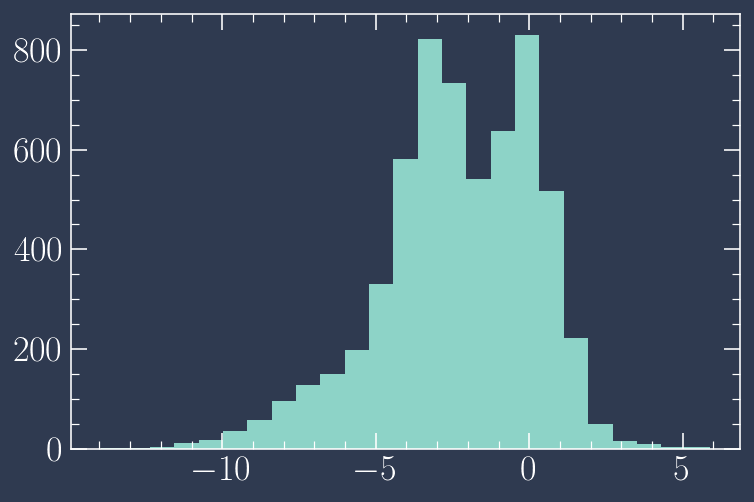

In [966]:
x = np.random.normal(loc=0, scale=0.90, size=(2000))
y = np.random.normal(loc=-4, scale=3, size=(2000))
z = np.random.normal(loc=-3, scale=1, size=(2000))
plt.hist(np.concatenate((x, y, z)), bins=25)
print(diptest.diptest(x))
print(diptest.diptest(np.concatenate((x, y, z))))

In [1044]:
def bootstrap_diptest(data, n_iterations=1000):
    dip_scores = np.zeros(n_iterations)
    p_values = np.zeros(n_iterations)

    for i in range(n_iterations):
        sample = resample(data)
        dip_score, p_value = diptest.diptest(sample)
        dip_scores[i] = dip_score
        p_values[i] = p_value

    return dip_scores, p_values


In [1015]:
# Generate a bootstrap distribution of dip test scores
bootstrap_scores = bootstrap_diptest(sampled_colors)

# Set a higher threshold for significance
threshold = np.percentile(bootstrap_scores, 40)  # Change the percentile value to adjust the threshold

# If the original dip score is higher than the threshold, consider it significant
original_dip_score, _ = diptest.diptest(sampled_colors)
if original_dip_score > threshold:
    print("Significant multimodality")
else:
    print("Not significant multimodality")

Not significant multimodality


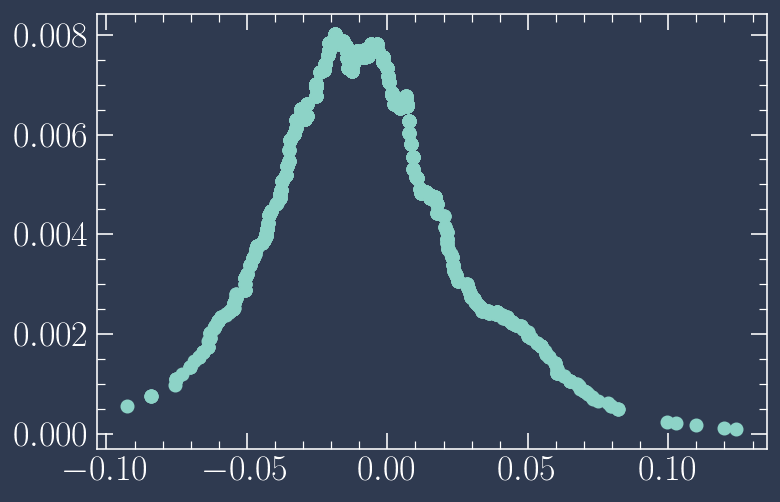

In [1016]:
plt.plot(sampled_colors, sampled_density, 'o')

(array([  6.,   7.,   3.,   7.,  21.,  38.,  53.,  72.,  77.,  98., 108.,
         99., 108.,  89.,  56.,  54.,  29.,  30.,  16.,   8.,   8.,   5.,
          3.,   4.,   1.]),
 array([0.02866572, 0.02926687, 0.02986803, 0.03046919, 0.03107034,
        0.0316715 , 0.03227265, 0.03287381, 0.03347496, 0.03407612,
        0.03467728, 0.03527843, 0.03587959, 0.03648074, 0.0370819 ,
        0.03768305, 0.03828421, 0.03888536, 0.03948652, 0.04008768,
        0.04068883, 0.04128999, 0.04189114, 0.0424923 , 0.04309345,
        0.04369461]),
 <BarContainer object of 25 artists>)

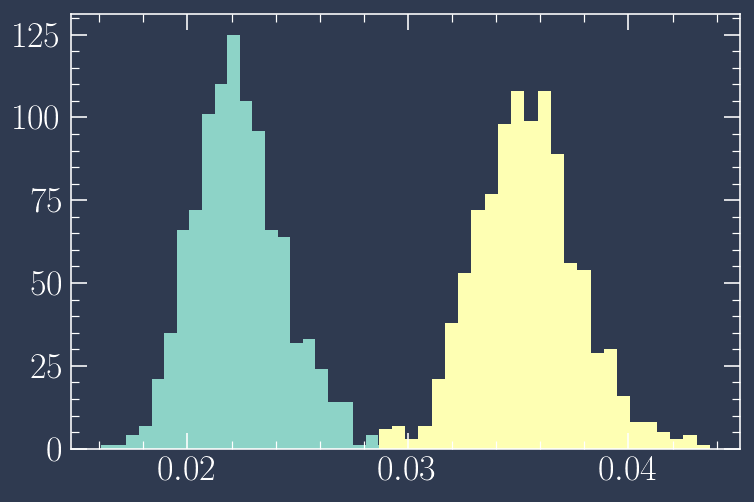

In [1018]:
plt.hist(bootstrap_scores, bins=25)
plt.hist(old_bsc, bins=25)

# Clean Start

In [40]:
def measure_bin(binID, n=50):
    cBinTemp, dBinTemp = vColorBins[binID], vDensityBins[binID].values
    cBinTemp, dBinTemp = cBinTemp[np.argsort(cBinTemp)], dBinTemp[np.argsort(cBinTemp)]

    gmm = BayesianGaussianMixture(n_components=n,
                                 random_state=42,
                                 weight_concentration_prior=1/(2*n),
                                 max_iter=500)

    weights = np.power(savgol_filter(dBinTemp, 20, 2), 2)
    weights = weights/np.sum(weights)

    colorNorm = cBinTemp/np.sum(cBinTemp)

    data = np.vstack((colorNorm, weights)).T
    gmmr = gmm.fit(data)
    gmm.fit(data)
    
    return gmm.predict(data)


[0.09011910198656975, 0.010193666438575416] [15.568715596330273, 15.8859085106383]


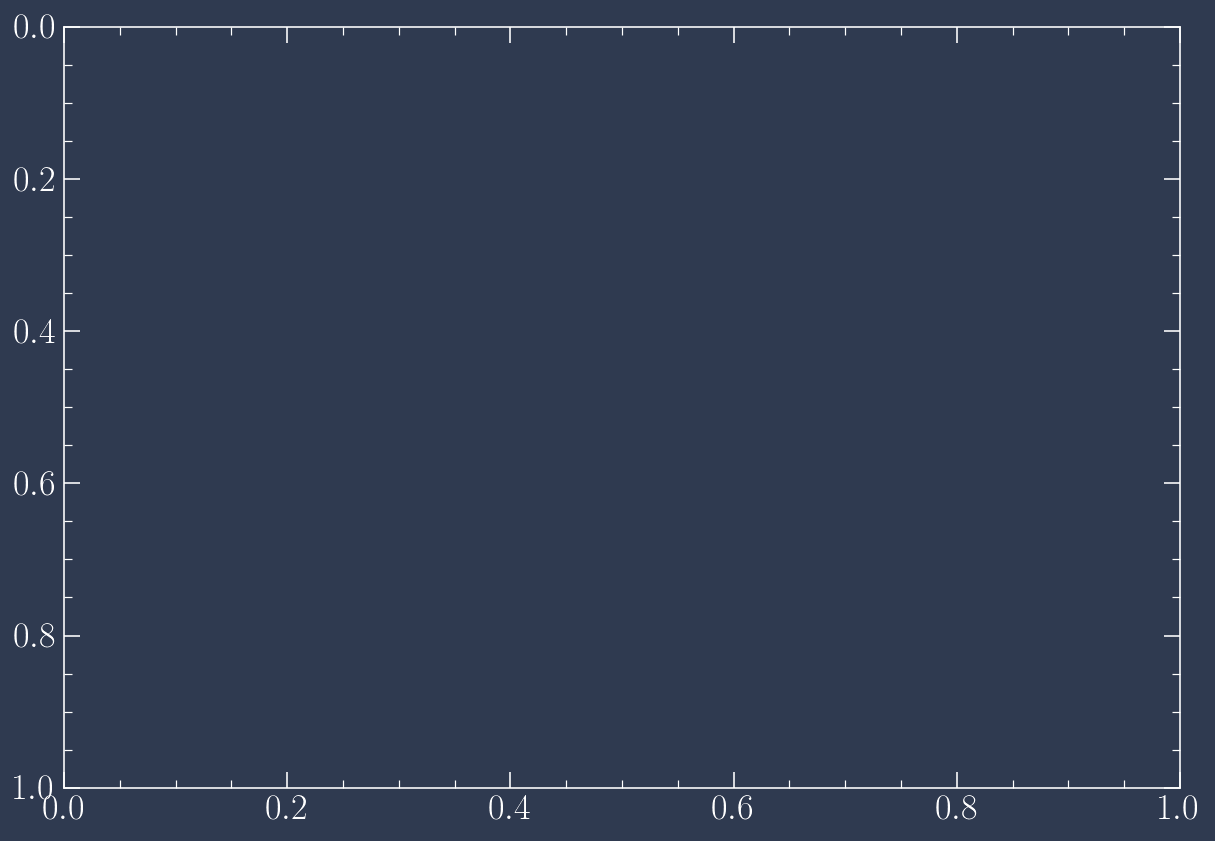

In [46]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
nClusters = 2
for ID, (color, mag, density) in enumerate(zip(vColorBins, vMagBins, vDensityBins)):
    p = measure_bin(ID, n=nClusters)
    clusterColorMeans = [sum(color[p==c])/len(color[p==c]) for c in np.unique(p)]
    clusterMagMeans = [sum(mag[p==c])/len(mag[p==c]) for c in np.unique(p)]
    print(clusterColorMeans, clusterMagMeans)
    break
    ax.scatter(color[p==0], mag[p==0], c='red',s=1)
    ax.scatter(color[p==1], mag[p==1], c='green', s=1)
    
ax.invert_yaxis()

In [47]:
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

def silhouette_analysis(dataset):
    """
    Perform silhouette analysis on the given dataset.

    Parameters:
    - dataset: A list of numpy arrays. Each numpy array has two columns representing color and mag respectively.

    Returns:
    - silhouette_avg: Average silhouette score for the entire dataset.
    - sample_silhouette_values: Silhouette score for each sample.
    """

    # Combine all clusters into one array for analysis and create labels based on cluster indices
    all_data = np.vstack(dataset)
    labels = np.hstack([i * np.ones(arr.shape[0], dtype=int) for i, arr in enumerate(dataset)])

    silhouette_avg = silhouette_score(all_data, labels)
    sample_silhouette_values = silhouette_samples(all_data, labels)
    
    return silhouette_avg, sample_silhouette_values

# Example usage:
# dataset = [np.array([[1, 2], [2, 3]]), np.array([[5, 6], [6, 7]])]
# silhouette_avg, sample_silhouette_values = silhouette_analysis(dataset)
# print("Average silhouette score:", silhouette_avg)


In [59]:
score = list()
for nClusters in range(2,10):
    scores = list()
    for ID, (color, mag, density) in enumerate(zip(vColorBins, vMagBins, vDensityBins)):
        p = measure_bin(ID, n=nClusters)
        dataset = [np.vstack((color[p==c], mag[p==c])).T for c in np.unique(p)]
        scores.append(silhouette_analysis(dataset)[0])
    averageScore = sum(scores)/len(scores)
    score.append(averageScoreerageScore)

with 2 an average score of 0.0286
with 3 an average score of -0.0230


/home/tboudreaux/anaconda3/envs/general/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/tboudreaux/anaconda3/envs/general/lib/python3.9/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


with 4 an average score of -0.0533
with 5 an average score of -0.0632
with 6 an average score of -0.0749
with 7 an average score of -0.0742
with 8 an average score of -0.0711
with 9 an average score of -0.0691


In [60]:
score = [0.0286, -0.0230, -0.0533, -0.0632, -0.0749, -0.0742, -0.0711, -0.0691]

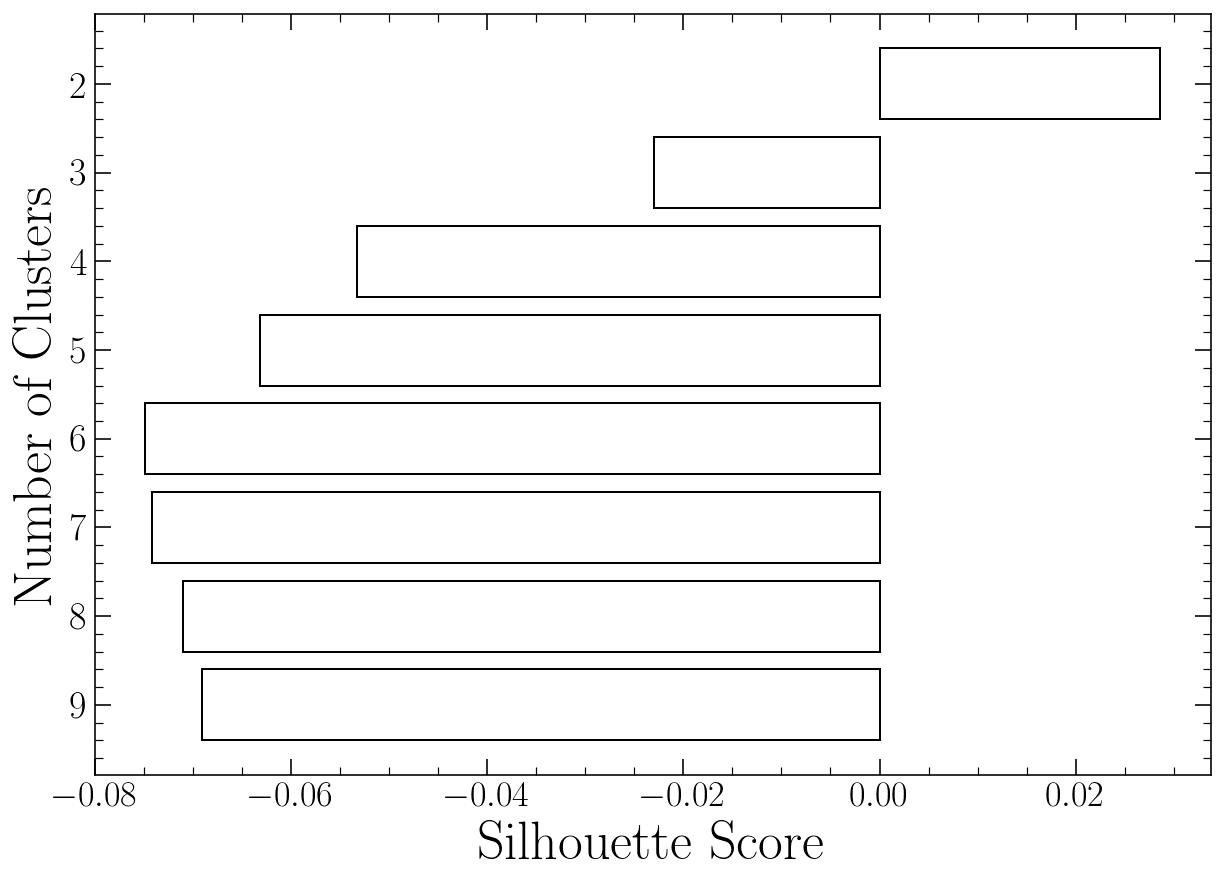

In [68]:
with plt.style.context(pubStyle):
    fig, ax = plt.subplots(1,1,figsize=(10,7))
    ax.barh(range(2,10), score, facecolor='white', edgecolor='black')
    ax.invert_yaxis()
    ax.set_xlabel("Silhouette Score", fontsize=27)
    ax.set_ylabel("Number of Clusters", fontsize=27)
    fig.savefig("ClusterAnalysis.pdf")